This code prices interest rate swaps based on a Nelson-Siegel-Svensson model using historical yield data from 01-01-2023 to 09-02-2024. 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import LSQUnivariateSpline

In [57]:
# Load CSV files
df_2015 = pd.read_csv('daily_treasury_rates_2015.csv', parse_dates=['Date'])
df_2016 = pd.read_csv('daily_treasury_rates_2016.csv', parse_dates=['Date'])
df_2017 = pd.read_csv('daily_treasury_rates_2017.csv', parse_dates=['Date'])
df_2018 = pd.read_csv('daily_treasury_rates_2018.csv', parse_dates=['Date'])
df_2019 = pd.read_csv('daily_treasury_rates_2019.csv', parse_dates=['Date'])
df_2020 = pd.read_csv('daily_treasury_rates_2020.csv', parse_dates=['Date'])
df_2021 = pd.read_csv('daily_treasury_rates_2021.csv', parse_dates=['Date'])
df_2022 = pd.read_csv('daily_treasury_rates_2022.csv', parse_dates=['Date'])
df_2023 = pd.read_csv('daily_treasury_rates_2023.csv', parse_dates=['Date'])
df_2024 = pd.read_csv('daily_treasury_rates_2024.csv', parse_dates=['Date'])

# Combine and sort the dataframes
df_combined = pd.concat([df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024]).sort_values(by='Date').reset_index(drop=True)

#df_combined = pd.concat([df_2023]).sort_values(by='Date').reset_index(drop=True)


# Convert rates to numeric and dates to datetime
for col in df_combined.columns[1:]:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

print(df_combined)

           Date  1 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr  \
0    2015-01-02  0.02  0.02  0.11  0.25  0.66  1.07  1.61  1.92   2.12   2.41   
1    2015-01-05  0.02  0.03  0.10  0.26  0.68  1.06  1.57  1.85   2.04   2.32   
2    2015-01-06  0.02  0.03  0.10  0.25  0.65  1.02  1.50  1.78   1.97   2.25   
3    2015-01-07  0.02  0.03  0.09  0.25  0.62  1.00  1.47  1.76   1.96   2.25   
4    2015-01-08  0.01  0.03  0.08  0.23  0.62  1.00  1.50  1.81   2.03   2.33   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...    ...    ...   
2274 2024-02-05  5.49  5.42  5.25  4.87  4.46  4.27  4.13  4.16   4.17   4.46   
2275 2024-02-06  5.48  5.44  5.23  4.82  4.39  4.14  4.03  4.07   4.09   4.39   
2276 2024-02-07  5.47  5.43  5.23  4.83  4.41  4.16  4.06  4.09   4.09   4.41   
2277 2024-02-08  5.49  5.44  5.24  4.83  4.46  4.22  4.12  4.15   4.15   4.47   
2278 2024-02-09  5.49  5.44  5.26  4.86  4.48  4.25  4.14  4.17   4.17   4.48   

      30 Yr  2 Mo  4 Mo  
0

In [58]:
def nss_model(t, beta_0, beta_1, beta_2, beta_3, tau_1, tau_2):
    term1 = beta_0
    term2 = beta_1 * ((1 - np.exp(-t / tau_1)) / (t / tau_1))
    term3 = beta_2 * (((1 - np.exp(-t / tau_1)) / (t / tau_1)) - np.exp(-t / tau_1))
    term4 = beta_3 * (((1 - np.exp(-t / tau_2)) / (t / tau_2)) - np.exp(-t / tau_2))
    return term1 + term2 + term3 + term4

def sse_nss(params, maturities, observed_rates):
    beta_0, beta_1, beta_2, beta_3, tau_1, tau_2 = params
    fitted_rates = nss_model(maturities, beta_0, beta_1, beta_2, beta_3, tau_1, tau_2)
    return np.sum((observed_rates - fitted_rates) ** 2)

In [59]:
# Set maturities based on the column names and convert to years
maturities = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])

# Use the latest available data for fitting
latest_rates = df_combined.iloc[0, 1:].values / 100  # Rates are in percentages in the file so convert to decimal

# Initial parameter guesses
initial_guess = [0.05, -0.1, 0.02, -0.06, 5, 12]

# Optimization
result = minimize(sse_nss, initial_guess, args=(maturities, latest_rates), method='L-BFGS-B')
params_fitted = result.x

print(params_fitted)

[ 0.05 -0.1   0.02 -0.06  5.   12.  ]


In [60]:
class InterestRateSwap:
    def __init__(self, notional, fixed_rate, maturity_years, payment_frequency):
        self.notional = notional
        self.fixed_rate = fixed_rate
        self.maturity_years = maturity_years
        self.payment_frequency = payment_frequency

    def calculate_pv(self, yield_curve, maturities):
        discount_factors = np.exp(-yield_curve(maturities) * maturities)
        fixed_cash_flows = self.notional * self.fixed_rate / self.payment_frequency
        pv = np.sum(fixed_cash_flows * discount_factors)
        return pv

In [61]:
# Example swap
notional = 1000000
fixed_rate = 0.025
maturity_years = 5
payment_frequency = 4  # Number of yearly payments

swap = InterestRateSwap(notional, fixed_rate, maturity_years, payment_frequency)

# Generate yield curve from NSS model for swap valuation
yield_curve = lambda t: nss_model(t, *params_fitted)
maturities_for_valuation = np.linspace(0.25, maturity_years, int(maturity_years * payment_frequency))

swap_pv = swap.calculate_pv(yield_curve, maturities_for_valuation)

print(f"The present value of the swap is: ${swap_pv:,.2f}")


The present value of the swap is: $133,791.09


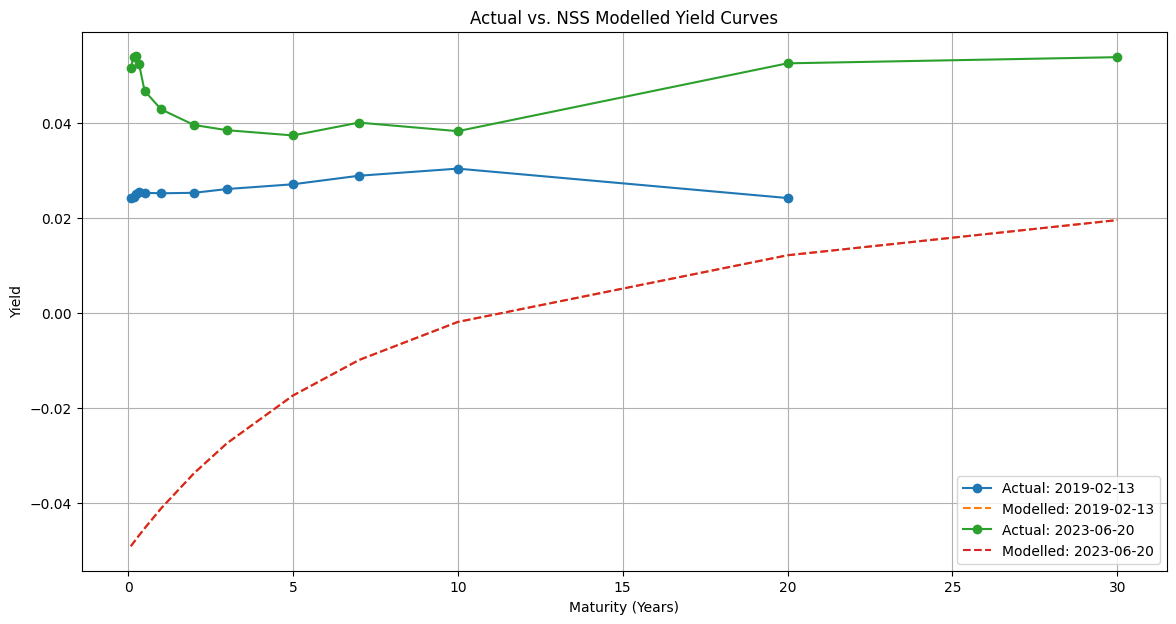

In [70]:
def plot_yield_curves(dates, df_combined, maturities, nss_params):
    
    plt.figure(figsize=(14, 7))
    
    # Generate NSS model curve once as it does not change with date
    model_rates = nss_model(maturities, *nss_params)
    
    # Plot for each date
    for date in dates:
        date_df = df_combined[df_combined['Date'] == pd.to_datetime(date)]
        if not date_df.empty:
            # Extract actual rates for the given date
            actual_rates = date_df.iloc[0, 1:].values / 100
            
            # Plotting
            plt.plot(maturities, actual_rates, marker='o', label=f'Actual: {date}')
            plt.plot(maturities, model_rates, label=f'Modelled: {date}', linestyle='--')
        else:
            print(f"No data available for {date}")
    
    plt.title('Actual vs. NSS Modelled Yield Curves')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Yield')
    plt.legend()
    plt.grid(True)
    plt.show()

# Select a few dates for visualization
dates_to_visualize = ['2019-02-13', '2023-06-20']  # Example dates

plot_yield_curves(dates_to_visualize, df_combined, maturities, params_fitted)


In [ ]:
# Choose knots based on domain knowledge or data analysis
knots = np.array([1, 2, 3, 5, 7, 10, 20])  # Chosen maturity points as knots

# Fit the spline to the term structure data
spline_model = LSQUnivariateSpline(terms, yields, knots, k=3)

# Evaluate the spline model on a range of terms
spline_yields = spline_model(terms)

# Plot the fitted spline against the actual data
plt.figure(figsize=(10, 6))
plt.plot(terms, yields, 'o', label='Actual data')
plt.plot(terms, spline_yields, label='Spline fit')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.legend()
plt.show()